In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
from datasets import Dataset
import pandas as pd
df = pd.read_csv("selected_questions_answers.csv")
dataset = Dataset.from_pandas(df)
selected_questions = dataset['Question']
selected_answers = dataset['Answer']

In [4]:
# ornek soru ve cevap
print("Örnek Soru:", selected_questions[999])
print("Örnek Cevap:", selected_answers[999])

Örnek Soru: En güçlü konuşma biçimini içeren cümleyi seçin.  (1) Fırtına bir canavar gibi şiddetleniyordu. (2) Fırtına bir aslan kadar vahşiydi. (3) Fırtına bir canavar kadar şiddetliydi. (4) Fırtına vahşi bir ejderhaydı.
Örnek Cevap: 4


In [5]:
from transformers import AutoTokenizer, AutoModel
import torch

# modeli yükleme ve vektör çıkartma
def get_model_and_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to('cuda')
    return tokenizer, model

# temsil çıkarma işlevi
def get_embeddings(texts, tokenizer, model):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to('cuda')
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :]

def get_embeddings_in_batches(texts, tokenizer, model, batch_size=16):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to('cuda')
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu() # GPU'dan CPU'ya taşıyoruz
        embeddings.append(batch_embeddings)
    torch.cuda.empty_cache()
    return torch.cat(embeddings)


In [6]:
from scipy.spatial.distance import cosine
import numpy as np

# kosinus benzerliğini hesaplama işlevi
def calculate_similarity(embedding1, embedding2):
    # kosinus mesafesi benzerliğin tersi oldugundan bu nedenle 1-cosine(embedding1, embedding2) olarak hesaplıyoruz
    similarity = 1 - cosine(embedding1, embedding2)
    return similarity

In [7]:
# top-1 ve top-5 başarı oranı hesaplama islevi
def calculate_top_k_success(questions, answers, tokenizer, model, batch_size=256, k=5):
    top1_count = 0
    top5_count = 0
    for idx, question in enumerate(questions):
        question_embedding = get_embeddings([question], tokenizer, model)[0].cpu().numpy()
        # tum cevapların embedding'lerini hesaplayalım

        similarities = []
        for i in range(0, len(answers), batch_size):
            batch_answers = answers[i:i + batch_size]
            batch_answer_embeddings = get_embeddings(batch_answers, tokenizer, model).cpu().numpy()

            # Soru ile bu parti arasındaki benzerlik skorlarını hesapla
            batch_similarities = [calculate_similarity(question_embedding, answer) for answer in batch_answer_embeddings]
            similarities.extend(batch_similarities)


        sorted_indices = np.argsort(similarities)[::-1]
        top_k_indices = sorted_indices[:k]

        # gercek cevabın indeksi k içerisinde ise sayacı arttıralım
        # idx = index
        if idx in top_k_indices:
            top5_count += 1
            if top_k_indices[0] == idx:
                top1_count += 1
        # ilk seferde calisip calismadigindan emin olmak icin step sayaci koydum bundan sonraki tum modellerde bu sayaci 50 ser 50 ser arttiriyorum cok fazla otuput olmamasi icin
        print('Step Complete - Index:',idx)
    top1_success_rate = top1_count / len(questions)
    top5_success_rate = top5_count / len(questions)

    return top1_success_rate, top5_success_rate

In [ ]:
# Model 1 - KaLM-embedding-multilingual-mini-v1
# Model 2 - pingkeest/learning2_model
# Model 3 - sentence-transformers/paraphrase-multilingual-mpnet-base-v2
# Model 4 - Alibaba-NLP/gte-multilingual-base
# Model 5 - Alibaba-NLP/gte-large-en-v1.5
# Model 6 - dbmdz/bert-base-turkish-cased

# kullanilacak model isimlerinin listesi
# ilk basta planim sirayla modelleri calistirmakti ancak uzun surmesinden oturu paralel olarak modelleri boldum
# ve kodu bir bir her model icin parelel olarak calistirdim
custom_model_names = [
    "pingkeest/learning2_model"
]

# her model için top-1 ve top-5 başarı oranlarını hesaplayalım
results = {}
for model_name in custom_model_names:
    print(f"Model: {model_name} yükleniyor...")
    tokenizer, model = get_model_and_tokenizer(model_name)

    print(f"{model_name} için top-1 ve top-5 başarı oranları hesaplanıyor...")
    top1_rate, top5_rate = calculate_top_k_success(selected_questions, selected_answers, tokenizer, model)

    results[model_name] = {
        "top1": top1_rate,
        "top5": top5_rate
    }

    print(f"{model_name} - Top-1 Başarı Oranı: {top1_rate:.2%}, Top-5 Başarı Oranı: {top5_rate:.2%}\n")


Model: pingkeest/learning2_model yükleniyor...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

The repository for pingkeest/learning2_model contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/pingkeest/learning2_model.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


configuration.py:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


The repository for pingkeest/learning2_model contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/pingkeest/learning2_model.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


modeling.py:   0%|          | 0.00/59.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

pingkeest/learning2_model için top-1 ve top-5 başarı oranları hesaplanıyor...
Step Complete - Index: 0
Step Complete - Index: 1
Step Complete - Index: 2
Step Complete - Index: 3
Step Complete - Index: 4
Step Complete - Index: 5
Step Complete - Index: 6
Step Complete - Index: 7
Step Complete - Index: 8
Step Complete - Index: 9
Step Complete - Index: 10
Step Complete - Index: 11
Step Complete - Index: 12
Step Complete - Index: 13
Step Complete - Index: 14
Step Complete - Index: 15
Step Complete - Index: 16
Step Complete - Index: 17
Step Complete - Index: 18
Step Complete - Index: 19
Step Complete - Index: 20
Step Complete - Index: 21
Step Complete - Index: 22
Step Complete - Index: 23
Step Complete - Index: 24
Step Complete - Index: 25
Step Complete - Index: 26
Step Complete - Index: 27
Step Complete - Index: 28
Step Complete - Index: 29
Step Complete - Index: 30
Step Complete - Index: 31
Step Complete - Index: 32
Step Complete - Index: 33
Step Complete - Index: 34
Step Complete - Index:

pingkeest/learning2_model için t-SNE görselleştirmesi oluşturuluyor...
The repository for pingkeest/learning2_model contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/pingkeest/learning2_model.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y
The repository for pingkeest/learning2_model contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/pingkeest/learning2_model.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


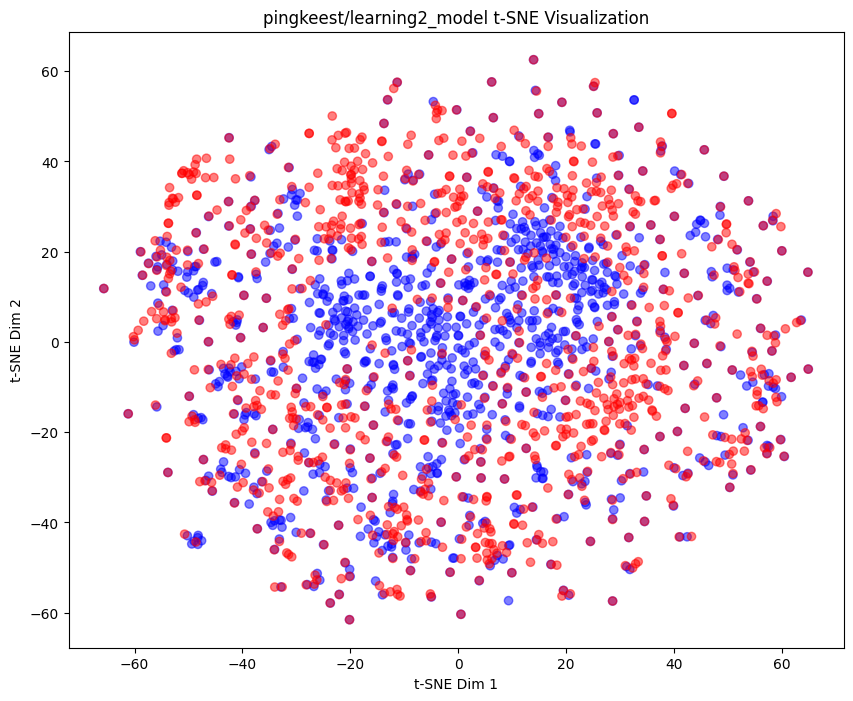

In [9]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# t-SNE uygulayarak gorsellestirdim
def plot_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    colors = ['blue' if label == 'question' else 'red' for label in labels]
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, alpha=0.5)
    plt.title(title)
    plt.xlabel('t-SNE Dim 1')
    plt.ylabel('t-SNE Dim 2')
    plt.show()

for model_name in custom_model_names:
    print(f"{model_name} için t-SNE görselleştirmesi oluşturuluyor...")
    tokenizer, model = get_model_and_tokenizer(model_name)

    # embedding alma
    question_embeddings = get_embeddings_in_batches(selected_questions, tokenizer, model).numpy()
    answer_embeddings = get_embeddings_in_batches(selected_answers, tokenizer, model).numpy()

    # t-SNE icin verileri birlestirme
    all_embeddings = np.vstack((question_embeddings, answer_embeddings))
    labels = ['question'] * len(selected_questions) + ['answer'] * len(selected_answers)

    # gorsellestirme
    plot_tsne(all_embeddings, labels, f"{model_name} t-SNE Visualization")
